# Robust Cross-Validated Causal Discovery

## 1. Setup and Data Preparation
This section imports necessary libraries and custom functions for data preprocessing, plotting, causal discovery, and evaluation.


In [1]:
import pandas as pd
import numpy as np
import time

print([np.__version__, pd.__version__])
np.set_printoptions(precision=3, suppress=True)


from src.data_preprocessing import preprocess_data
from src.plotting import plot_time_series, plot_heatmap, plot_causal_graph
from src.causal_matrix_evaluation import evaluate_causal_matrices, interpret_evaluation_metrics
from src.run_causal_discovery import run_varlingam, run_pcmci
from src.rcv_varlingam import run_rcv_varlingam, grid_search_rcv_varlingam
from src.rcv_pcmci import run_rcv_pcmci, grid_search_rcv_pcmci

['1.24.4', '2.0.3']


## 2. Causal Discovery Algorithms and Execution
Here we introduce and execute our causal discovery algorithms to get the correlation matrices and visualise the results.

### 2.1 VAR-LiNGAM (Vector Autoregressive Linear Non-Gaussian Acyclic Model)
VAR-LiNGAM is a causal discovery algorithm that estimates a linear non-Gaussian acyclic model from time series data. It is based on the principle of independent component analysis (ICA) and is designed to identify the causal relationships between variables in a multivariate time series.

### 2.2 PCMCI (Peter and Clark Momentary Conditional Independence)
PCMCI is a causal discovery algorithm that estimates causal relationships between variables in a multivariate time series using conditional independence tests. It is based on the principle of Granger causality and can identify both linear and non-linear causal relationships.



1. Loading, plotting, and preprocessing data...
Dataset shape: (1000, 5)


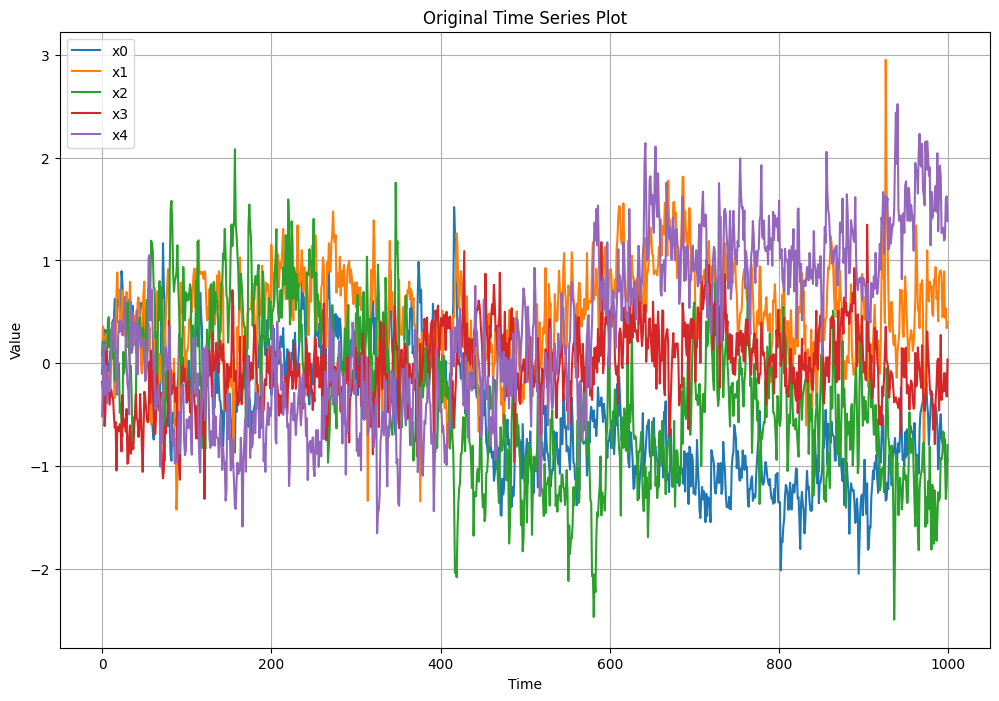


2. Running causal discovery method...

3. Printing results...
Adjacency matrices: [array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [-0.239,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]]), array([[ 0.715,  0.   ,  0.035, -0.253,  0.   ],
       [ 0.   ,  0.722,  0.   , -0.211,  0.   ],
       [ 0.   ,  0.   ,  0.808,  0.229,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.555,  0.   ],
       [ 0.   ,  0.   , -0.293,  0.   ,  0.687]]), array([[0.135, 0.   , 0.   , 0.078, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.157, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.137]])]
Execution time: 0.6782791614532471 seconds

4. Visualizing results...


<Figure size 640x480 with 0 Axes>

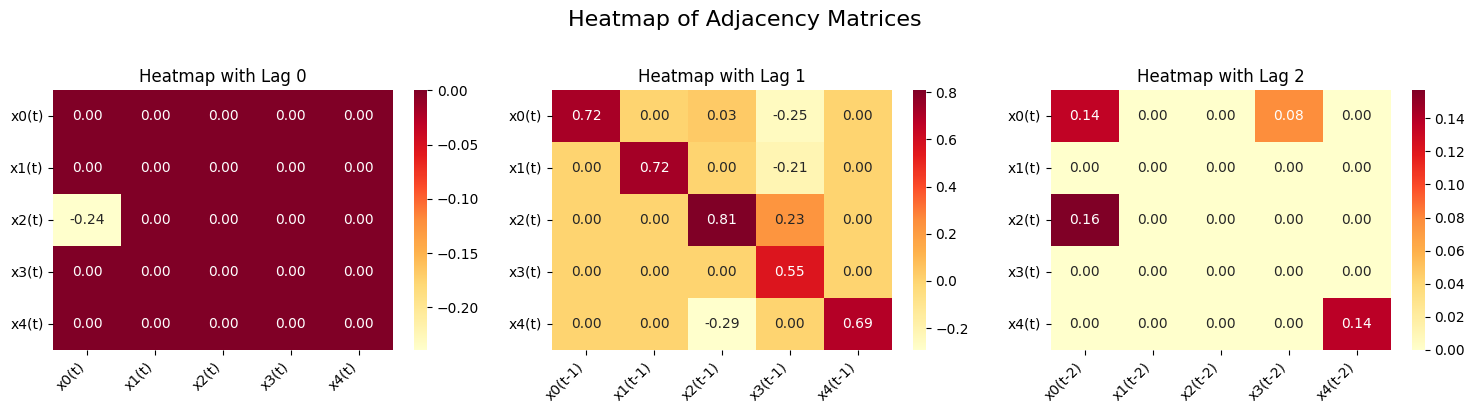

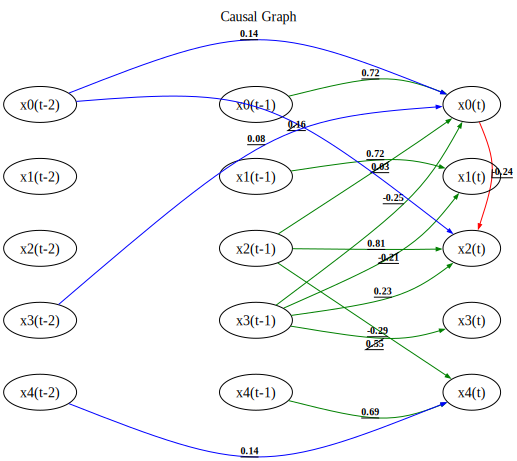

<Figure size 640x480 with 0 Axes>

In [2]:
# 1. Load, plot, and preprocess data
print("\n1. Loading, plotting, and preprocessing data...")
data = pd.read_csv('data/synthetic/scale_5_var/dataset_0.csv')
columns = data.columns.tolist()
if "Date" in columns:
    data = data.drop(['Date'], axis=1).values
    columns.remove('Date')
else:
    data = data.values
print("Dataset shape:", data.shape)

# Plot original time series
plot_time_series(data, columns, title="Original Time Series Plot")

# Preprocess data
data = preprocess_data(data, columns)

# 2. Run causal discovery method
print("\n2. Running causal discovery method...")
method = "rcv_varlingam"  # Choose from: 'varlingam', 'pcmci', 'rcv_varlingam', 'rcv_pcmci'

start_time = time.time()

if method == 'varlingam':
    results = run_varlingam(data)
    adjacency_matrices = results.adjacency_matrices_
elif method == 'pcmci':
    adjacency_matrices = run_pcmci(data, columns)
elif method == 'rcv_varlingam':
    adjacency_matrices = run_rcv_varlingam(data, n_splits=7, consistency_threshold=0.7, variability_threshold=0.4, adjustment_weight=0.1)
elif method == 'rcv_pcmci':
    adjacency_matrices = run_rcv_pcmci(data, n_splits=3, consistency_threshold=0.1, variability_threshold=0.1, adjustment_weight=0.1)
else:
    print("Invalid method chosen")
    exit()

end_time = time.time()

# 3. Print results and execution time
print("\n3. Printing results...")
print("Adjacency matrices:", adjacency_matrices)
print(f"Execution time: {end_time - start_time} seconds")

# 4. Visualize results
print("\n4. Visualizing results...")
plot_heatmap(adjacency_matrices, columns)
causal_graph = plot_causal_graph(adjacency_matrices, node_labels=columns)
display(causal_graph)

## 3. Performance Comparison and Analysis
This section focuses on comparing the performance of standard VAR-LiNGAM with Robust Cross-Validated VAR-LiNGAM and standard PCMCI with Robust Cross-Validated PCMCI. We evaluate the causal discovery results using the ground truth causal graph and visualise the results.

### 3.1 Comparison of Standard and Robust Cross-Validated VAR-LiNGAM

In [7]:
def ground_truth_to_matrices(csv_path):
    # Read the CSV file
    with open(csv_path, 'r') as f:
        content = f.read()

    # Split the content by double newlines to separate matrices
    matrix_strings = content.strip().split('\n\n')
    
    # Convert each matrix string to a numpy array
    matrices = []
    for matrix_string in matrix_strings:
        matrix = np.array([list(map(float, row.split(','))) for row in matrix_string.split('\n')])
        matrices.append(matrix)
    
    return matrices

# Function to load ground truth
def load_ground_truth():
    ground_truth_path = f'data/synthetic/scale_20_var/ground_truth.csv'
    try:
        return ground_truth_to_matrices(ground_truth_path)
    except FileNotFoundError:
        print(f"Ground truth file not found: {ground_truth_path}")
        return None


1. Defining ground truth matrices...

2. Loading, plotting, and preprocessing data...
Dataset shape: (1000, 20)

3. Running standard VAR-LiNGAM...
Execution time: 2.2356228828430176 seconds

Standard VAR-LiNGAM Results:
[Structural Hamming Distance] Fair: 171 (86.36%). Significant structural differences.
[f1] Fair: 0.657. Moderate accuracy in identifying causal relationships.
[F1→] Fair: 0.649. Moderate accuracy in identifying directed causal relationships.
[Frobenius Norm] Poor: 2.040. Large discrepancies between true and estimated matrices.
[lags] Overestimation: Estimated 3 lags, with 1 extra lags.

4. Running Robust Cross-Validated VAR-LiNGAM...
Execution time: 10.019468069076538 seconds

Robust Cross-Validated VAR-LiNGAM Results:
[Structural Hamming Distance] Good: 105 (53.03%). Some structural differences.
[f1] Fair: 0.691. Moderate accuracy in identifying causal relationships.
[F1→] Fair: 0.685. Moderate accuracy in identifying directed causal relationships.
[Frobenius Norm] Po

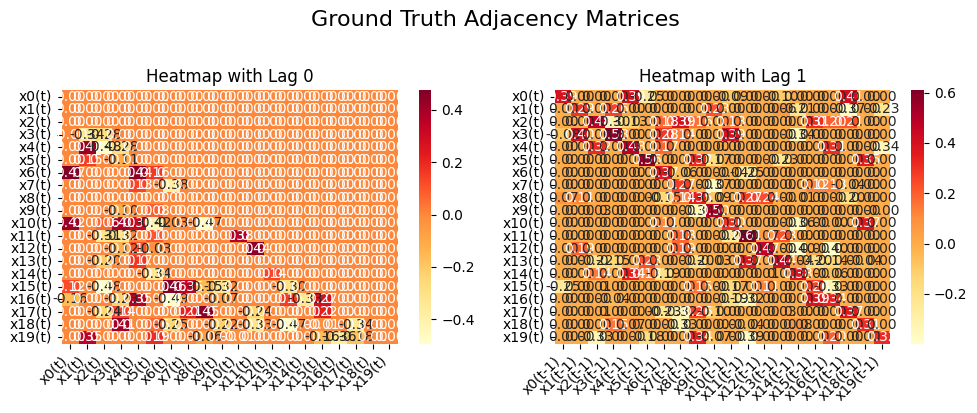

<Figure size 640x480 with 0 Axes>

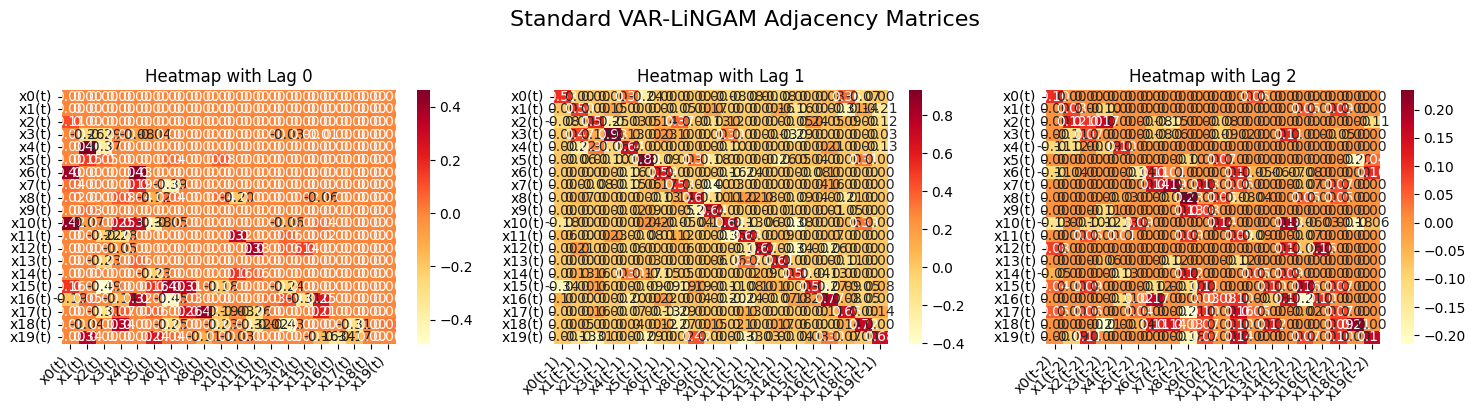

<Figure size 640x480 with 0 Axes>

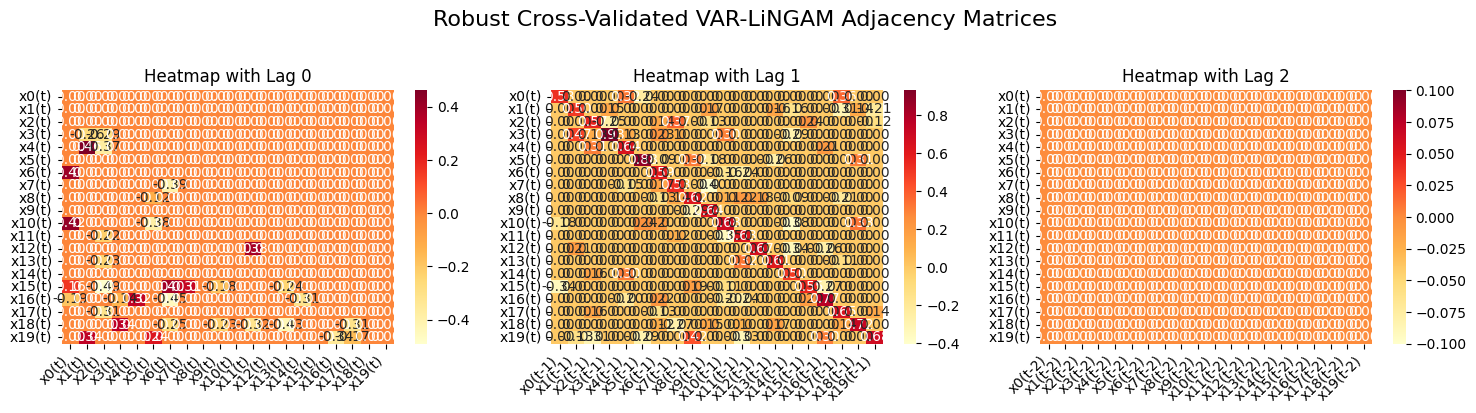

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
# 1. Define ground truth matrices
print("\n1. Defining ground truth matrices...")
ground_truth_matrices = load_ground_truth()

# 2. Load and preprocess data
print("\n2. Loading, plotting, and preprocessing data...")
data_path = 'data/synthetic/scale_20_var/dataset_6.csv'
data = pd.read_csv(data_path)
columns = data.columns.tolist()
if "Date" in columns:
    data = data.drop(['Date'], axis=1).values
    columns.remove('Date')
else:
    data = data.values

print(f"Dataset shape: {data.shape}")

# Preprocess data
log_vars = None
percent_vars = None
data = preprocess_data(data, columns, log_vars=log_vars, percent_vars=percent_vars)

# 3. Run standard VAR-LiNGAM
print("\n3. Running standard VAR-LiNGAM...")
start_time = time.time()
varlingam_model = run_varlingam(data)
standard_varlingam_matrices = varlingam_model.adjacency_matrices_
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

print("\nStandard VAR-LiNGAM Results:")
standard_comparison = evaluate_causal_matrices(ground_truth_matrices, standard_varlingam_matrices)
standard_interpretations = interpret_evaluation_metrics(standard_comparison)
for metric, interpretation in standard_interpretations.items():
    print(f"[{metric}] {interpretation}")

# 4. Run Robust Cross-Validated VAR-LiNGAM
print("\n4. Running Robust Cross-Validated VAR-LiNGAM...")
start_time = time.time()
rcv_varlingam_matrices = run_rcv_varlingam(data, n_splits=5, consistency_threshold=0.7, variability_threshold=0.4, adjustment_weight=0)
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

print("\nRobust Cross-Validated VAR-LiNGAM Results:")
rcv_comparison = evaluate_causal_matrices(ground_truth_matrices, rcv_varlingam_matrices)
rcv_interpretations = interpret_evaluation_metrics(rcv_comparison)
for metric, interpretation in rcv_interpretations.items():
    print(f"[{metric}] {interpretation}")

# 5. Compare improvements
print("\n5. Comparing improvements...")
for metric in ["shd", "f1", "f1_directed", "fro"]:
    standard_value = standard_comparison[metric]
    rcv_value = rcv_comparison[metric]
    
    if metric in ["shd", "fro"]:
        improvement = standard_value - rcv_value
        better_word = "decrease" if improvement > 0 else "increase"
    else:  # for f1 and f1_directed
        improvement = rcv_value - standard_value
        better_word = "increase" if improvement > 0 else "decrease"
    
    print(f"{metric}: {better_word} of {abs(improvement):.4f}")
    print(f"  Standard: {standard_value:.4f}")
    print(f"  RCV     : {rcv_value:.4f}")
    
    if (metric in ["fro", "shd"] and improvement > 0) or (metric in ["f1", "f1_directed"] and improvement > 0):
        print("  Improvement: Yes")
    else:
        print("  Improvement: No")
    print()

# 6. Visualize results
print("\n6. Visualizing results...")
plot_heatmap(ground_truth_matrices, columns, title="Ground Truth Adjacency Matrices")
plot_heatmap(standard_varlingam_matrices, columns, title="Standard VAR-LiNGAM Adjacency Matrices")
plot_heatmap(rcv_varlingam_matrices, columns, title="Robust Cross-Validated VAR-LiNGAM Adjacency Matrices")

#### Hyperparameter Optimization with Grid Search (RCV-VARLiNGAM)


1. Loading, plotting, and preprocessing data...
Dataset shape: (1000, 5)


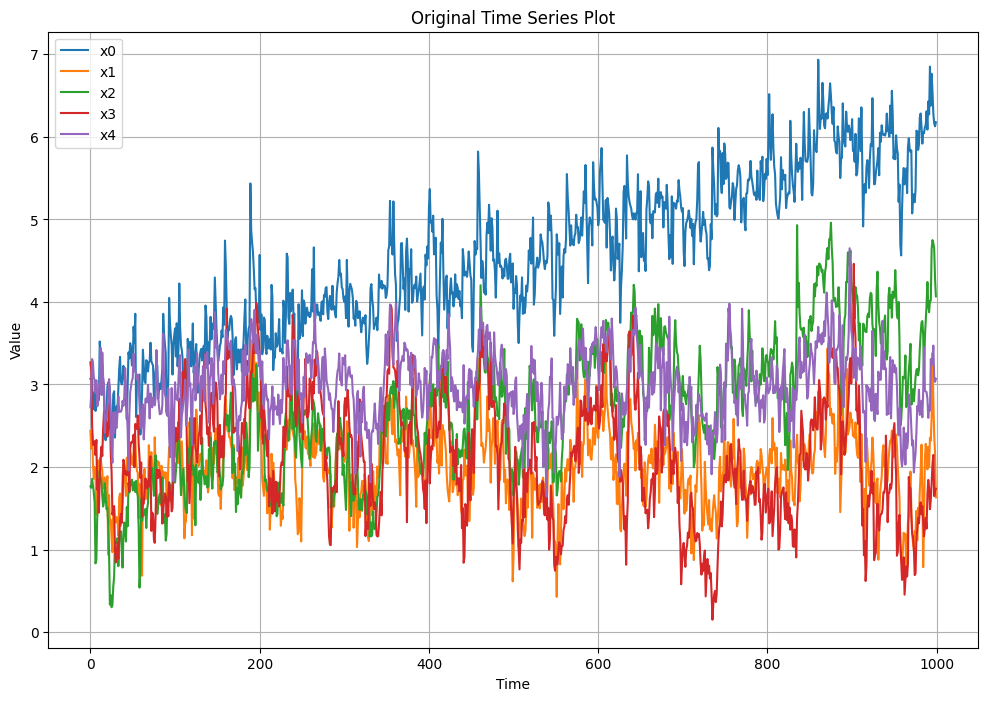


2. Defining ground truth matrices...

3. Performing grid search for RCV-VAR-LiNGAM...
True combined: 
 [[0.  0.  0.  0.  0.  0.6 0.  0.1 0.  0. ]
 [0.4 0.  0.  0.  0.  0.  0.5 0.  0.1 0. ]
 [0.  0.3 0.  0.  0.  0.  0.  0.7 0.  0. ]
 [0.1 0.  0.2 0.  0.  0.  0.  0.  0.8 0. ]
 [0.2 0.  0.  0.1 0.  0.  0.  0.2 0.  0.4]]
Est combined: 
 [[0.    0.    0.    0.    0.    0.692 0.    0.    0.    0.   ]
 [0.398 0.    0.    0.    0.    0.    0.58  0.    0.087 0.116]
 [0.    0.    0.    0.    0.    0.    0.    0.723 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.797 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.458]]
True combined: 
 [[0.  0.  0.  0.  0.  0.6 0.  0.1 0.  0. ]
 [0.4 0.  0.  0.  0.  0.  0.5 0.  0.1 0. ]
 [0.  0.3 0.  0.  0.  0.  0.  0.7 0.  0. ]
 [0.1 0.  0.2 0.  0.  0.  0.  0.  0.8 0. ]
 [0.2 0.  0.  0.1 0.  0.  0.  0.2 0.  0.4]]
Est combined: 
 [[0.    0.    0.    0.    0.    0.7   0.    0.    0.    0.   ]
 [0.393 0.    0.    0.    0.    0.  

<Figure size 640x480 with 0 Axes>

In [4]:
# 1. Load, plot, and preprocess data
print("\n1. Loading, plotting, and preprocessing data...")
data_path = 'data/test_data_with_trends_random.csv'
data = pd.read_csv(data_path)
columns = data.columns.tolist()
if "Date" in columns:
    data = data.drop(['Date'], axis=1).values
    columns.remove('Date')
else:
    data = data.values

print(f"Dataset shape: {data.shape}")
plot_time_series(data, columns, title="Original Time Series Plot")

# Preprocess data
log_vars = None
percent_vars = None
data = preprocess_data(data, columns, log_vars=log_vars, percent_vars=percent_vars)

# 2. Define true matrices (ground truth)
print("\n2. Defining ground truth matrices...")
ground_truth_matrices = load_ground_truth()

# 3. Perform grid search
print("\n3. Performing grid search for RCV-VAR-LiNGAM...")
grid_search_results = grid_search_rcv_varlingam(data, ground_truth_matrices)

print("\nBest parameters:")
for param, value in grid_search_results['best_params'].items():
    print(f"{param}: {value}")
print(f"Best F1 score (directed): {grid_search_results['best_score']:.4f}")

# 4. Evaluate best matrices
print("\n4. Evaluating best matrices...")
best_matrices = grid_search_results['best_matrices']
evaluation_results = evaluate_causal_matrices(ground_truth_matrices, best_matrices)
interpretations = interpret_evaluation_metrics(evaluation_results)

print("\nBest RCV-VAR-LiNGAM Results:")
for metric, interpretation in interpretations.items():
    print(f"[{metric}] {interpretation}")

### 3.2 Comparison of Standard and Robust Cross-Validated PCMCI

In [ ]:
# 1. Define ground truth matrices
print("\n1. Defining ground truth matrices...")
ground_truth_matrices = load_ground_truth()

# 2. Load and preprocess data
print("\n2. Loading, plotting, and preprocessing data...")
data_path = 'data/synthetic/scale_20_var/dataset_6.csv'
data = pd.read_csv(data_path)
columns = data.columns.tolist()
if "Date" in columns:
    data = data.drop(['Date'], axis=1).values
    columns.remove('Date')
else:
    data = data.values

print(f"Dataset shape: {data.shape}")

# Preprocess data
log_vars = None
percent_vars = None
data = preprocess_data(data, columns, log_vars=log_vars, percent_vars=percent_vars)

# 3. Run standard PCMCI
print("\n3. Running standard PCMCI...")
start_time = time.time()
standard_pcmci_matrices = run_pcmci(data, columns)
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

print("\nStandard PCMCI Results:")
standard_comparison = evaluate_causal_matrices(ground_truth_matrices, standard_pcmci_matrices)
standard_interpretations = interpret_evaluation_metrics(standard_comparison)
for metric, interpretation in standard_interpretations.items():
    print(f"[{metric}] {interpretation}")

# 4. Run Robust Cross-Validated PCMCI
print("\n4. Running Robust Cross-Validated PCMCI...")
start_time = time.time()
rcv_pcmci_matrices = run_rcv_pcmci(data, n_splits=7, consistency_threshold=0.7, variability_threshold=0.4, adjustment_weight=0)
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

print("\nRobust Cross-Validated PCMCI Results:")
rcv_comparison = evaluate_causal_matrices(ground_truth_matrices, rcv_pcmci_matrices)
rcv_interpretations = interpret_evaluation_metrics(rcv_comparison)
for metric, interpretation in rcv_interpretations.items():
    print(f"[{metric}] {interpretation}")

# 5. Compare improvements
print("\n5. Comparing improvements...")
for metric in ["shd", "f1", "f1_directed", "fro"]:
    standard_value = standard_comparison[metric]
    rcv_value = rcv_comparison[metric]
    
    if metric in ["shd", "fro"]:
        improvement = standard_value - rcv_value
        better_word = "decrease" if improvement > 0 else "increase"
    else:  # for f1 and f1_directed
        improvement = rcv_value - standard_value
        better_word = "increase" if improvement > 0 else "decrease"
    
    print(f"{metric}: {better_word} of {abs(improvement):.4f}")
    print(f"  Standard: {standard_value:.4f}")
    print(f"  RCV     : {rcv_value:.4f}")
    
    if (metric in ["fro", "shd"] and improvement > 0) or (metric in ["f1", "f1_directed"] and improvement > 0):
        print("  Improvement: Yes")
    else:
        print("  Improvement: No")
    print()

# 6. Visualize results
print("\n6. Visualizing results...")
plot_heatmap(standard_pcmci_matrices, columns, title="Standard PCMCI Adjacency Matrices")
plot_heatmap(rcv_pcmci_matrices, columns, title="Robust Cross-Validated PCMCI Adjacency Matrices")
plot_heatmap(ground_truth_matrices, columns, title="Ground Truth Adjacency Matrices")

#### Hyperparameter Optimization with Grid Search (RCV-PCMCI)


1. Loading, plotting, and preprocessing data...
Dataset shape: (1000, 5)


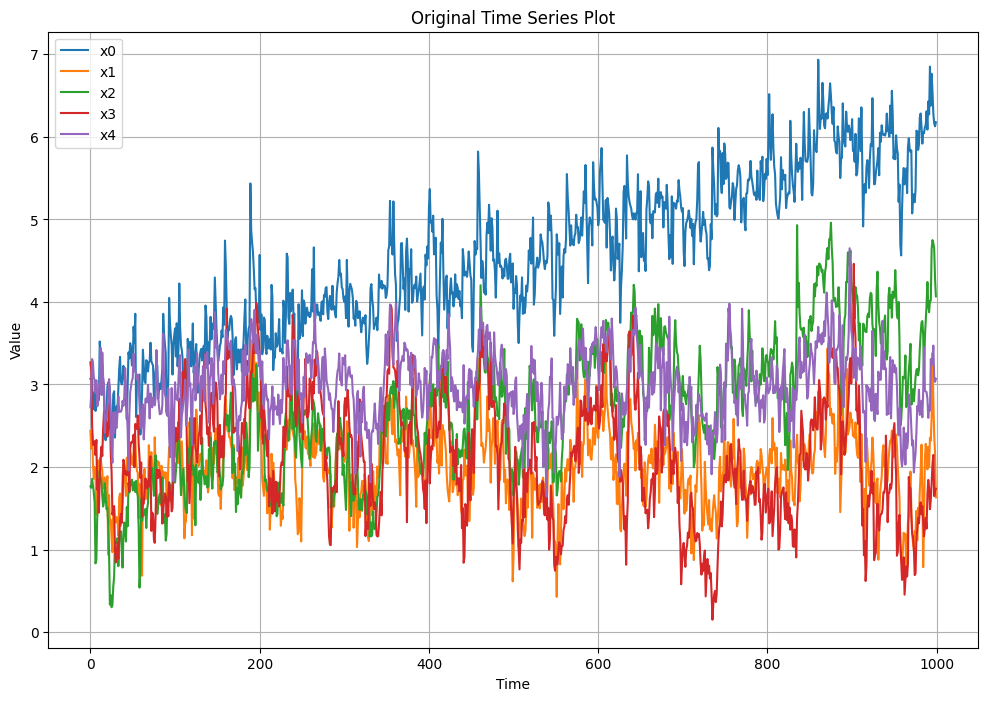


2. Defining ground truth matrices...

3. Performing grid search for RCV-VAR-LiNGAM...

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 5 link(s):
        (0 -1): max_pval = 0.00000, |min_val| =  0.585
        (2 -1): max_pval = 0.00003, |min_val| =  0.132
        (1 -1): max_pval = 0.00473, |min_val| =  0.090
        (4 -1): max_pval = 0.02296, |min_val| =  0.072
        (0 -2): max_pval = 0.04369, |min_val| =  0.064

    Variable 1 has 3 link(s):
        (1 -1): max_pval = 0.00000, |min_val| =  0.572
        (4 -1): max_pval = 0.00002, |min_val| =  0.136
        (3 -1): max_pval = 0.03428, |min_val| =  0.067

    Variable 2 has 3 link(s):
        (2 -1): max_pval = 0.00000, |min_val| =  0.664
        (0 -1): max_pval = 0.00001, |min_val| =  0.144
        (1 -1): max_pval = 0.00196, |

<Figure size 640x480 with 0 Axes>

In [6]:
# 1. Load, plot, and preprocess data
print("\n1. Loading, plotting, and preprocessing data...")
data_path = 'data/test_data_with_trends_random.csv'
data = pd.read_csv(data_path)
columns = data.columns.tolist()
if "Date" in columns:
    data = data.drop(['Date'], axis=1).values
    columns.remove('Date')
else:
    data = data.values

print(f"Dataset shape: {data.shape}")
plot_time_series(data, columns, title="Original Time Series Plot")

# Preprocess data
log_vars = None
percent_vars = None
data = preprocess_data(data, columns, log_vars=log_vars, percent_vars=percent_vars)

# 2. Define true matrices (ground truth)
print("\n2. Defining ground truth matrices...")
ground_truth_matrices = load_ground_truth()

# 3. Perform grid search
print("\n3. Performing grid search for RCV-VAR-LiNGAM...")
grid_search_results = grid_search_rcv_pcmci(data, ground_truth_matrices)

print("\nBest parameters:")
for param, value in grid_search_results['best_params'].items():
    print(f"{param}: {value}")
print(f"Best F1 score (directed): {grid_search_results['best_score']:.4f}")

# 4. Evaluate best matrices
print("\n4. Evaluating best matrices...")
best_matrices = grid_search_results['best_matrices']
evaluation_results = evaluate_causal_matrices(ground_truth_matrices, best_matrices)
interpretations = interpret_evaluation_metrics(evaluation_results)

print("\nBest RCV-VAR-LiNGAM Results:")
for metric, interpretation in interpretations.items():
    print(f"[{metric}] {interpretation}")